<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session7/EVA_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Network Architectures:

The objective behind this assignment seems to be to help us use the functional API to build models by utilizing skip connections etc.

The model to be created can be found [here](https://canvas.instructure.com/courses/1587436/assignments/11447393?module_item_id=23697884)

###Importing Modules:

We utilize the code snippen below to import modules to our runtime so that we can use the interfaces exposed by these modules to write and adjust our CNN. We describe only a few modules below that we have not covered in previous assignments:

- **ModelCheckpoint** : This is among the many callbacks provided by Keras that we can use while training our model. We will use this to store the best model weights so that we do not loose out on them by updations performed during subsequent epochs ([Documentation](https://keras.io/callbacks/))

- **ImageDataGenerator** : This module helps us perform image augmentation which is a very strong regularization measure. We can use this to apply transformations like rotation, translation, random crop etc. on out training dataset before passing them on to the network ([Documentation](https://keras.io/preprocessing/image/))

- **Dropout** : This a keras layer that implements dropouts. Dropouts are another regurarization mechanism that drop certain pixel values while training the model so that our model does not overfit to the training images ([Documentation](https://keras.io/layers/core/))

- **Lambda** : This is a keras layer that wraps any given function as a layer of the network architecture

In [0]:
from keras import backend as K
import keras
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Concatenate, Add, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf

### Loading and Pre-Processing the Data:

Some details about the dataset:

- Name : Cifar10
- Number of classes : 10
- Training set size : 50K
- Test set size : 10K
- Image resolution : 32x32

In the code below, we :

- Load the data extracted from a tar.gz file into python variables *(train_features, test_features , test_labels and train_labels)*
- Each of the images are in shape *[3, 32, 32]* and labels are simple integers


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Plotting model history:

In the code below, we define a utility function that takes the history returned by the *fit_generator()* function and plots the record of the accuracies and losses:

- Plot the train and test accuracies recorded after every epoch
- Plot the train and test losses recorded after every epoch


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###Getting the accuracy:

The code below defines a utility function that calculates the accuracy given:

- Training Images of shape *(batch_size, height, width, num_channels)*
- Training labels of shape *(batch_size, num_classes)*
- Returns accuracy in percentage


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###Wrapping our layers

Since Each convolution layer will involve batch normalization and an activation layer, it would be very verbose to define every layer using the functional API. As an alternative we do the following:

- The method **add_skip_connection(layers = [])** adds a skip connection by adding the layers passed as arguments - These layers must be of the same shape - Something the code ideally should validate

- The method **reshape()** uses the tensorflow utility *tf.nn.space_to depth()* in order to move the spatial dimension of the image to the depth dimension. This is required to have skip connections b.w layers with different channel sizes

- The method **get_convolution()** implements the following 4 cases of convolution given the filter sizes etc:
-- Separable with BN
-- Separable w/o BN
-- Normal with BN
-- Normal w/o BN






In [0]:
def add_skip_conn(layers = []):
  return Activation('relu')(Add()(layers))

def reshape(x, block_size):
    return tf.nn.space_to_depth(x, block_size)


def get_convolution(x, is_separable = False, kernel_size = 3, num_filters = 16, isBatchNorm = True):
  if is_separable:
    if isBatchNorm:
      x = Conv2D(num_filters, (1,kernel_size), padding = 'same', use_bias = False)(x)
      return Activation('relu')(
          BatchNormalization()(
          Conv2D(num_filters, (kernel_size,1), padding = 'same', use_bias = False)(
          x)))
    else:
      x = Conv2D(num_filters, (1,kernel_size), padding = 'same', use_bias = False)(x)
      return Activation('relu')(
          Conv2D(num_filters, (kernel_size,1), padding = 'same', use_bias = False)(
          x))
  else:
    if isBatchNorm:
      return Activation('relu')(
      BatchNormalization()(
      Conv2D(num_filters, (kernel_size,kernel_size), padding = 'same', use_bias = False)(x)))
    else:
      return Activation('relu')(
      Conv2D(num_filters, (kernel_size,1), padding = 'same', use_bias = False)(x))
    
    
  

###Defining our model:

We use the functions we define above to create the model as prescribed by the diagram in the Assignment. Couple of things to notice:

- Variables names as *x_hat* or *x_prime* are essentially versions of older output in a smaller channel size to facilitate skip connections across MaxPooling layers

- Around 900K learnable parameters

- We use pointwise convolution in *out17* to match the depth dimension in order to facilitate skip connections

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 8)    120         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 8)    320         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 8)    32          conv2d_23[0][0]                  
____________________________________________________________________________________________

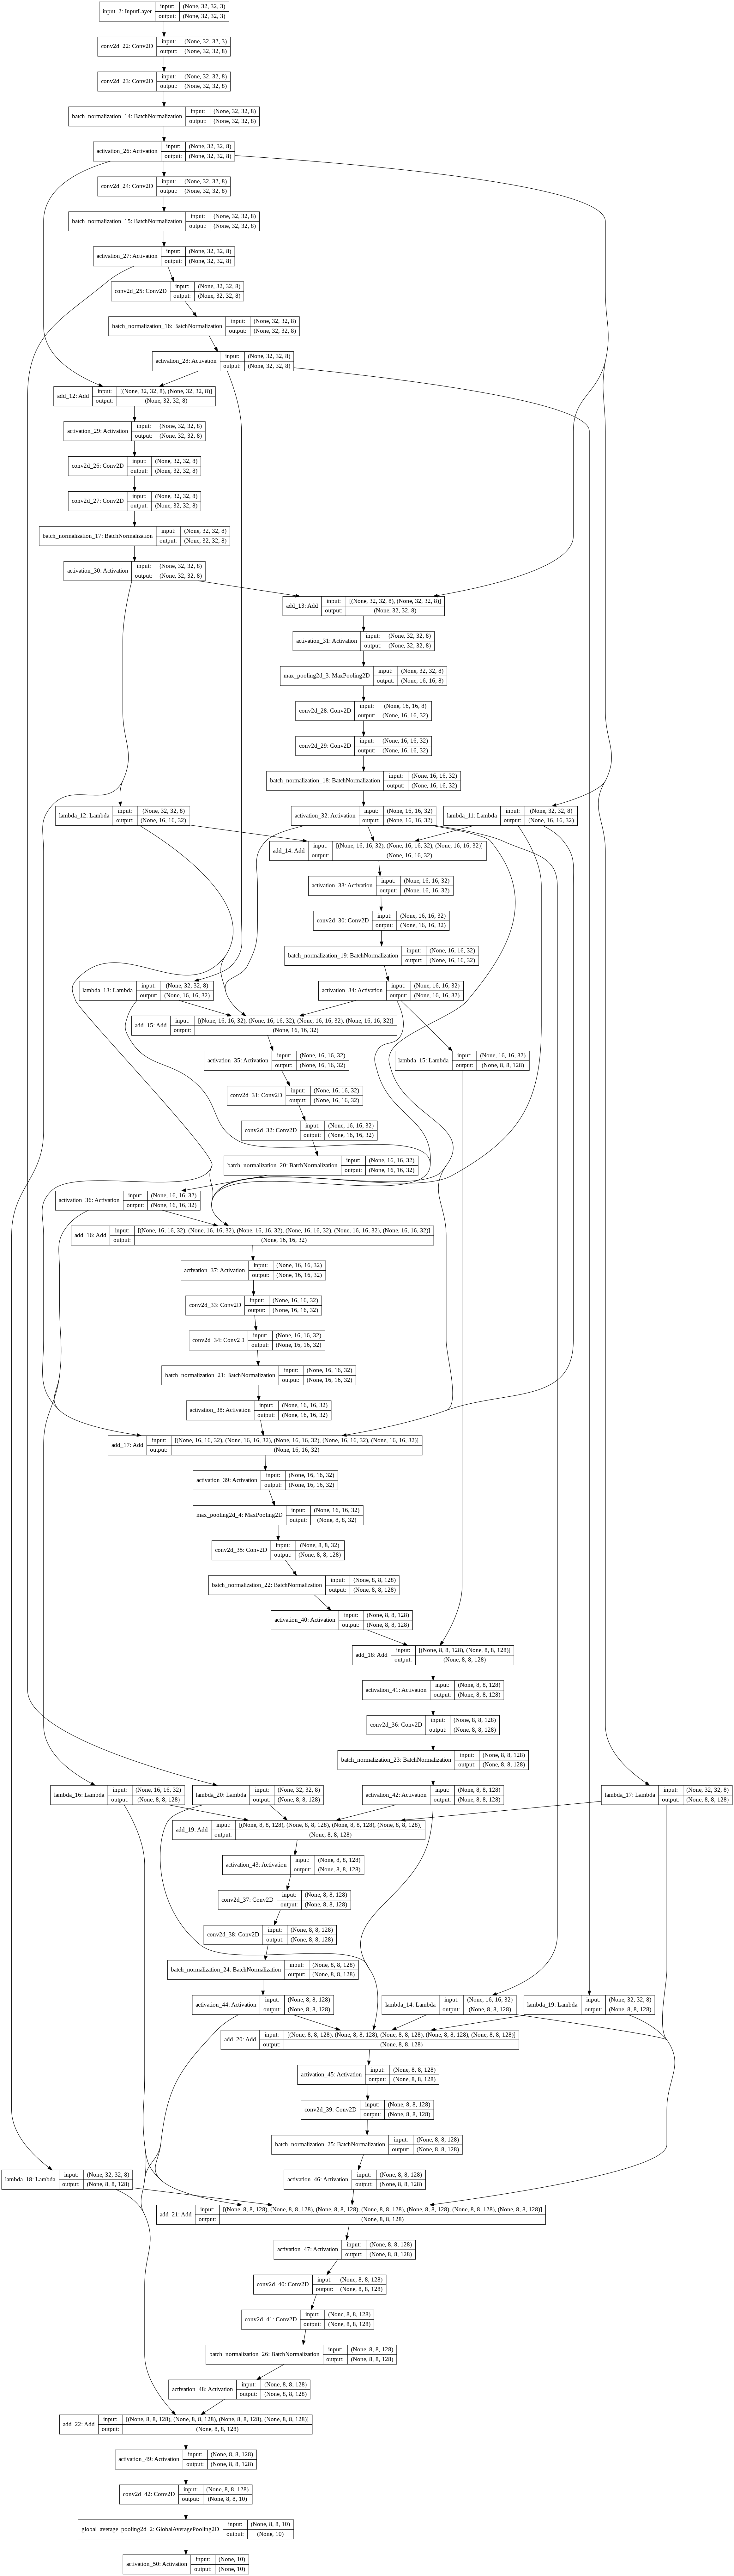

In [15]:
inp = Input(shape = (32,32,3))

out1 = get_convolution(inp, True, 5, 8, True)

out2 = get_convolution(out1, False, 5, 8, True)

out3 = get_convolution(out2, False, 5, 8, True )

out4 = add_skip_conn([out1, out3])



out5 = get_convolution(out4, True, 5, 8, True)

out6 = add_skip_conn([out5, out1])



out7 = MaxPooling2D()(out6)

# out1_hat = Reshape([16,16,-1])(out1)
out1_hat = Lambda(reshape,arguments = {'block_size' : 2})(out1)
out5_hat = Lambda(reshape,arguments = {'block_size' : 2})(out5)
out3_hat = Lambda(reshape,arguments = {'block_size' : 2})(out3)

out8 = get_convolution(out7, True, 3, 32, True)

out9 = add_skip_conn([out8, out5_hat, out1_hat])

out10 = get_convolution(out9, False, 5, 32, True)

out11 = add_skip_conn([out10, out8, out5_hat, out3_hat])

out12 = get_convolution(out11, True, 3, 32, True)

out13 = add_skip_conn([out12, out10, out8, out3_hat, out1_hat, out5_hat])

out14 = get_convolution(out13, True, 5, 32, True)

out15 = add_skip_conn([out14, out12, out5_hat, out8, out1_hat])

out16 = MaxPooling2D()(out15)

out17 = get_convolution(out16, False, 1, 128, True)

out8_prime = Lambda(reshape,arguments = {'block_size' : 2})(out8)
out10_prime = Lambda(reshape,arguments = {'block_size' : 2})(out10)
out12_prime = Lambda(reshape,arguments = {'block_size' : 2})(out12)
out1_prime = Lambda(reshape,arguments = {'block_size' : 4})(out1)
out5_prime = Lambda(reshape,arguments = {'block_size' : 4})(out5)
out3_prime = Lambda(reshape,arguments = {'block_size' : 4})(out3)
out2_prime = Lambda(reshape,arguments = {'block_size' : 4})(out2)

out17 = add_skip_conn([out17, out10_prime])

out18 = get_convolution(out17, False, 5, 128, True)

out19 = add_skip_conn([out18, out12_prime, out2_prime, out1_prime])

out20 = get_convolution(out19, True, 5, 128, True)

out21 = add_skip_conn([out20, out18, out3_prime, out2_prime, out8_prime])

out22 = get_convolution(out21, False, 3, 128, True)

out23 = add_skip_conn([out22, out3_prime, out12_prime, out20, out5_prime, out8_prime, out1_prime])

out24 = get_convolution(out23, True, 5, 128, True)

out25 = add_skip_conn([out24, out12_prime, out20, out5_prime])

out26 = Conv2D(10,(1,1), padding = 'same', use_bias = False)(out25)

out27 = GlobalAveragePooling2D()(out26)

out28 = Activation('softmax')(out27)











model = keras.Model(inputs = inp, outputs = out28)

print(model.summary())

keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)


###Training our model:

We use the following steps to train our better model:

- We **normalize** the train and test images before passing them through the network
- We **save the best** model obtained after each epoch
- The best model thus obtained gives us an accuracy of 88.11%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=100)`


Epoch 1/100
390/390 [==============================] - 49s 126ms/step - loss: 1.0944 - acc: 0.6077 - val_loss: 2.4182 - val_acc: 0.4371

Epoch 00001: val_acc improved from -inf to 0.43710, saving model to best_model.hdf5
Epoch 2/100
390/390 [==============================] - 46s 117ms/step - loss: 0.9486 - acc: 0.6614 - val_loss: 2.0033 - val_acc: 0.5057

Epoch 00002: val_acc improved from 0.43710 to 0.50570, saving model to best_model.hdf5
Epoch 3/100
390/390 [==============================] - 46s 117ms/step - loss: 0.8533 - acc: 0.6989 - val_loss: 2.1866 - val_acc: 0.4467

Epoch 00003: val_acc did not improve from 0.50570
Epoch 4/100
390/390 [==============================] - 46s 117ms/step - loss: 0.7859 - acc: 0.7235 - val_loss: 1.7195 - val_acc: 0.4773

Epoch 00004: val_acc did not improve from 0.50570
Epoch 5/100
390/390 [==============================] - 46s 117ms/step - loss: 0.7322 - acc: 0.7417 - val_loss: 1.1984 - val_acc: 0.6325

Epoch 00005: val_acc improved from 0.50570 t

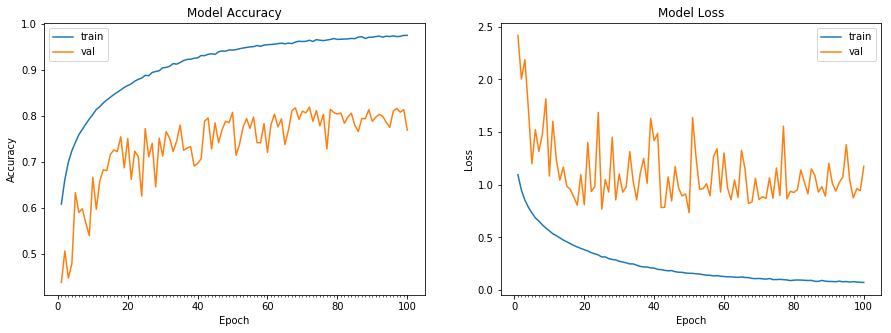

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 390, nb_epoch = 100, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
plot_model_history(model_info)

In [20]:
model.load_weights('./best_model.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 81.87
